In [ ]:
! git clone "https://github.com/AbdurRahman328/Dermnet.git"

Cloning into 'Dermnet'...
remote: Enumerating objects: 6536, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 6536 (delta 0), reused 3 (delta 0), pack-reused 6533
Receiving objects: 100% (6536/6536), 591.22 MiB | 24.43 MiB/s, done.
Updating files: 100% (6900/6900), done.


##Importing Libraries

In [ ]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.utils import to_categorical



##Load and preprocess the training data


In [ ]:
labels = ['Acne','Actinic','Atopic','Lupus']

X_train = []
y_train = []
image_size = 160
for i in labels:
    folderPath = os.path.join('/content/Dermnet/train/',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)



100%|██████████| 420/420 [00:02<00:00, 180.72it/s]


##Splitting Data to Training and Testing

In [ ]:
num_classes = len(labels)
x_train, x_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.2, random_state = 101)

Encode labels using LabelEncoder

In [ ]:

le = LabelEncoder()
categories = labels
le.fit(categories)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

##Convert labels to one-hot encoding

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.utils import to_categorical

y_train1=np.array(y_train)
y_test1=np.array(y_test)
train_Y_one_hot = to_categorical(y_train1)
test_Y_one_hot = to_categorical(y_test)


x_train2 = np.zeros((len(x_train),160,160,3),dtype='uint8')
for i in range(0,len(x_train)):
        x_train2[i,:,:,:]=x_train[i]
x_test2=np.zeros((len(x_test),160,160,3),dtype='uint8')
for i in range(0,len(x_test)):
        x_test2[i,:,:,:]=x_test[i]


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.losses import CategoricalCrossentropy

##Define and compile the model architecture

In [ ]:
def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))


    for layer in base_model.layers:
        layer.trainable = False

    from keras.optimizers import Adam
    custom_optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer= custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


## Load and preprocess data for federated learning

In [ ]:
def load_data():

     y_train1=np.array(y_train)
     y_test1=np.array(y_test)

     train_Y_one_hot = to_categorical(y_train1)
     test_Y_one_hot = to_categorical(y_test)


     x_train2=np.zeros((len(x_train),160,160,3),dtype='uint8')
     for i in range(0,len(x_train)):
             x_train2[i,:,:,:]=x_train[i]

     x_test2=np.zeros((len(x_test),160,160,3),dtype='uint8')
     for i in range(0,len(x_test)):
             x_test2[i,:,:,:]=x_test[i]

     return x_train2, y_train1, x_test2, y_test1



In [ ]:
from keras.preprocessing.image import ImageDataGenerator

##Federated Averaging with Momentum


In [ ]:
def federated_averaging_with_momentum(global_model, client_models, momentum=0.9):
    # Aggregate model weights with momentum
    average_weights = []
    for layer in range(len(global_model.get_weights())):
        momentum_term = 0.0
        for client in client_models:
            client_weights = client.get_weights()[layer]
            momentum_term += momentum * (client_weights - global_model.get_weights()[layer])
        average_weights.append(global_model.get_weights()[layer] + momentum_term / len(client_models))
    global_model.set_weights(average_weights)


## Federated Learning

In [ ]:
def federated_learning(num_clients=10, num_epochs=5):
    global_model = create_model()
    x_train, y_train, x_test, y_test = load_data()
    client_data_size = len(x_train2) // num_clients

    client_models = [create_model() for _ in range(num_clients)]
    client_accuracies = []
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
  
    datagen.fit(x_train2)

    overall_history = {'loss': [], 'accuracy': []}
    
    for client_id in range(num_clients):
        test_loss, test_acc = client_models[client_id].evaluate(x_test2, y_test1, verbose=0)
        client_accuracies.append(test_acc)
        print(f"Client {client_id + 1} (Before Training): Accuracy = {test_acc:.4f}")
        
    for client_id in range(num_clients):
        start_idx = client_id * client_data_size
        end_idx = start_idx + client_data_size
        x_local, y_local = x_train2[start_idx:end_idx], y_train1[start_idx:end_idx]

        history = client_models[client_id].fit(x_local, y_local, epochs=num_epochs,batch_size = 64, verbose=1)
        
        test_loss, test_acc = client_models[client_id].evaluate(x_test2, y_test1, verbose=0)
        print(f"Client {client_id + 1}: Accuracy = {test_acc:.4f}, Loss = {test_loss:.4f}")

    print("Client Accuracies (Before Training):", client_accuracies)


    federated_averaging_with_momentum(global_model,client_models,momentum=0.9)
    test_loss, test_acc = global_model.evaluate(x_test2, y_test1)
    train_loss, train_acc = global_model.evaluate(x_train2, y_train1)
    return global_model



In [ ]:
global_model=federated_learning(num_clients=5,num_epochs=20)

Client 1 (Before Training): Accuracy = 0.3069
Client 2 (Before Training): Accuracy = 0.2155
Client 3 (Before Training): Accuracy = 0.2224
Client 4 (Before Training): Accuracy = 0.2276
Client 5 (Before Training): Accuracy = 0.2914
Epoch 1/20
8/8 [==============================] - 3s 120ms/step - loss: 1.7384 - accuracy: 0.4752
Epoch 2/20
8/8 [==============================] - 1s 122ms/step - loss: 0.7469 - accuracy: 0.7235
Epoch 3/20
8/8 [==============================] - 1s 124ms/step - loss: 0.5574 - accuracy: 0.7905
Epoch 4/20
8/8 [==============================] - 1s 124ms/step - loss: 0.4424 - accuracy: 0.8531
Epoch 5/20
8/8 [==============================] - 1s 124ms/step - loss: 0.3362 - accuracy: 0.8963
Epoch 6/20
8/8 [==============================] - 1s 125ms/step - loss: 0.2806 - accuracy: 0.9028
Epoch 7/20
8/8 [==============================] - 1s 126ms/step - loss: 0.2129 - accuracy: 0.9352
Epoch 8/20
8/8 [==============================] - 1s 126ms/step - loss: 0.2027 - acc

##Confusion Matrix

19/19 [==============================] - 2s 73ms/step


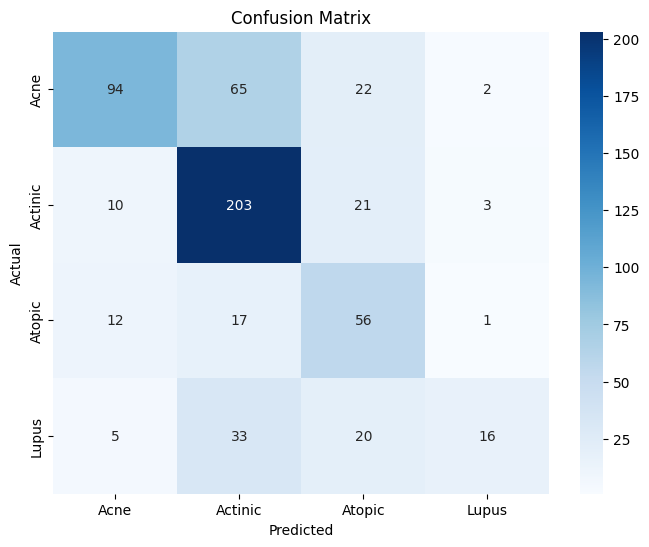

In [ ]:
def generate_confusion_matrix(model, x_data, y_data, labels):
    predictions = model.predict(x_data)
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_data, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


generate_confusion_matrix(global_model, x_test2, y_test1, labels)


##Classification Report

In [ ]:
from sklearn.metrics import classification_report

def evaluate_metrics(model, x_data, y_data, labels):
    predictions = model.predict(x_data)
    y_pred = np.argmax(predictions, axis=1)
    
    report = classification_report(y_data, y_pred, target_names=labels)
    print("Classification Report:\n", report)


evaluate_metrics(global_model, x_test2, y_test1, labels)


19/19 [==============================] - 1s 70ms/step
Classification Report:
               precision    recall  f1-score   support

        Acne       0.78      0.51      0.62       183
     Actinic       0.64      0.86      0.73       237
      Atopic       0.47      0.65      0.55        86
       Lupus       0.73      0.22      0.33        74

    accuracy                           0.64       580
   macro avg       0.65      0.56      0.56       580
weighted avg       0.67      0.64      0.62       580



##ROC curve

19/19 [==============================] - 1s 67ms/step


<ipython-input-18-ec68962c168d>:40: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')


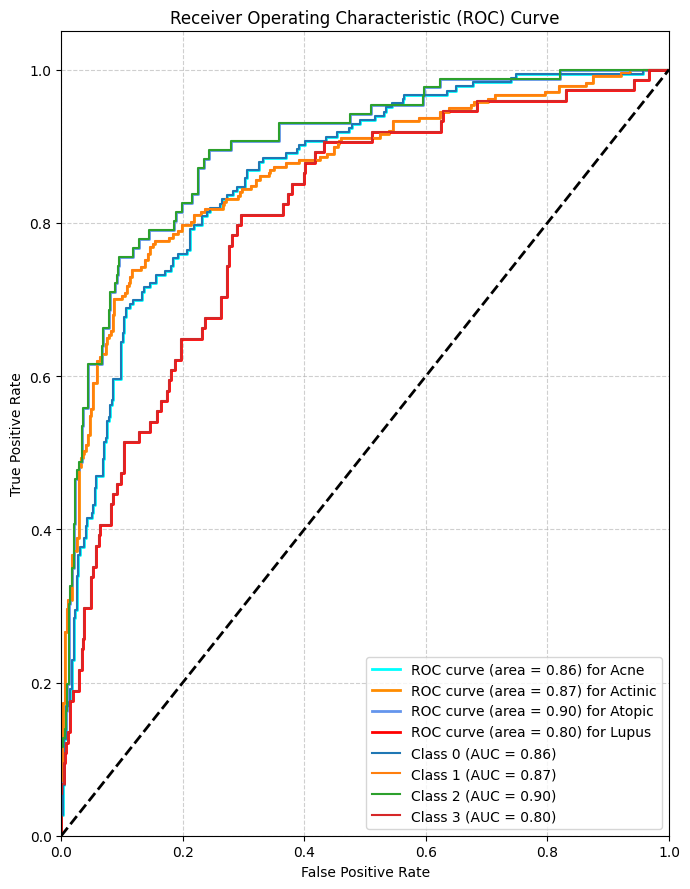

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

def plot_roc_curve(model, x_data, y_data, num_classes, class_labels):
    y_data_one_hot = label_binarize(y_data, classes=range(num_classes))
    y_score = model.predict(x_data)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_data_one_hot[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    fpr["micro"], tpr["micro"], _ = roc_curve(y_data_one_hot.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(7, 9))
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'ROC curve (area = {roc_auc[i]:.2f}) for {class_labels[i]}')

   
    for i in range(num_classes):
     plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

   
    plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
plot_roc_curve(global_model, x_test2, y_test1, num_classes=len(labels), class_labels=labels)





##Image Prediction

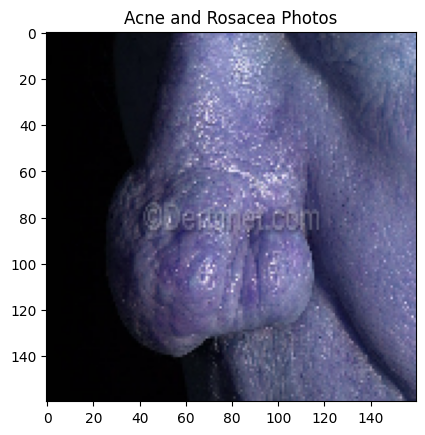


1/1 [==============================] - 1s 919ms/step
Actual Label: Acne and Rosacea Photos
Predicted value: Acne



In [ ]:
import os

paths = ['/content/Dermnet/test/Acne and Rosacea Photos/07Rhinophyma1.jpg']

for i in paths:
    img = cv2.imread(i)


    if img is not None:
        img = cv2.resize(img, (image_size, image_size))
        input_data = np.array(img)

        image_to_visualize = input_data

        # Display the image
        plt.imshow(image_to_visualize)
        plt.title(i.split('/')[-2])
        plt.show()

        input_single_image = np.expand_dims(input_data, axis=0)
        print()

        predicted = global_model.predict(input_single_image)
        print("Actual Label:", i.split('/')[-2])
        print("Predicted value:", labels[predicted.argmax()])

        print()
    else:
        print(f"Error loading image: {i}")
